In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

survey = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')

all_data = pd.DataFrame()
total = 0

for root, folder, files in os.walk('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/smart_meter/15min_interval'):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, low_memory=False)
            all_data = pd.concat([all_data, data], ignore_index=True)
            rows, cols = data.shape
            total = total + rows

#this notebook will be dealing with selected columns as below
all_data_filtered = all_data[['household_ID', 'date', 'time', 'importkwh(kwh)', 'exportkwh(kwh)']].copy()

all_data_filtered['time'] = all_data_filtered['time'].str.extract(r'(\d{2}:\d{2}:\d{2})')

all_data_filtered['DATETIME'] = pd.to_datetime(all_data_filtered['date'] + ' ' + all_data_filtered['time'], errors='coerce')

# plot

merged = all_data_filtered.merge(survey[['household_ID', 'no_of_electricity_meters']], on='household_ID', how='inner')

total_households = merged['household_ID'].nunique()
unique_daily_households = merged.drop_duplicates(subset=['date', 'household_ID'])
households_per_day = unique_daily_households.groupby('date')['household_ID'].nunique()
percentage_per_day = (households_per_day / 1877) * 100




plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_per_day.index, y=percentage_per_day.values)
# x axis only should only show from month to month
plt.xticks(ticks=range(0, len(percentage_per_day.index), 30), labels=percentage_per_day.index[::30], rotation=45)
# y axis should go till 100
plt.ylim(0, 100)
plt.xticks(rotation=45)

#plt.title('Percentage of Households Having atleast One Record per Day')
plt.xlabel('Date')
plt.ylabel('Percentage of Households (%)')


In [4]:
#sort all_data_filtered by DATETIME
#all_data_filtered.sort_values('DATETIME', inplace=True)
#all_data_filtered[all_data_filtered['household_ID'] == 'ID4878'].head(50)

Text(0, 0.5, 'Percentage of Households (%)')

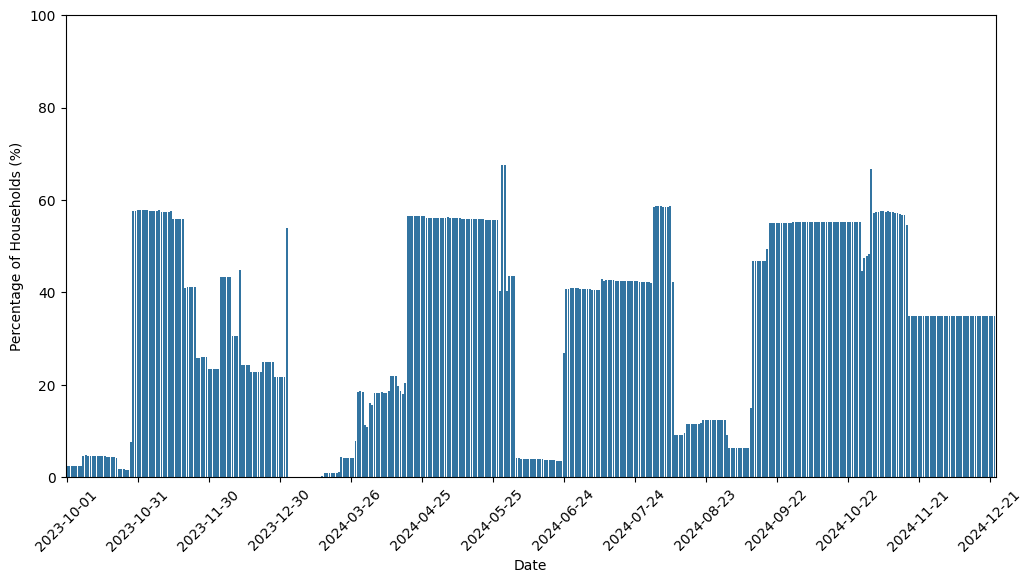

Text(0, 0.5, 'Percentage of Households (%)')

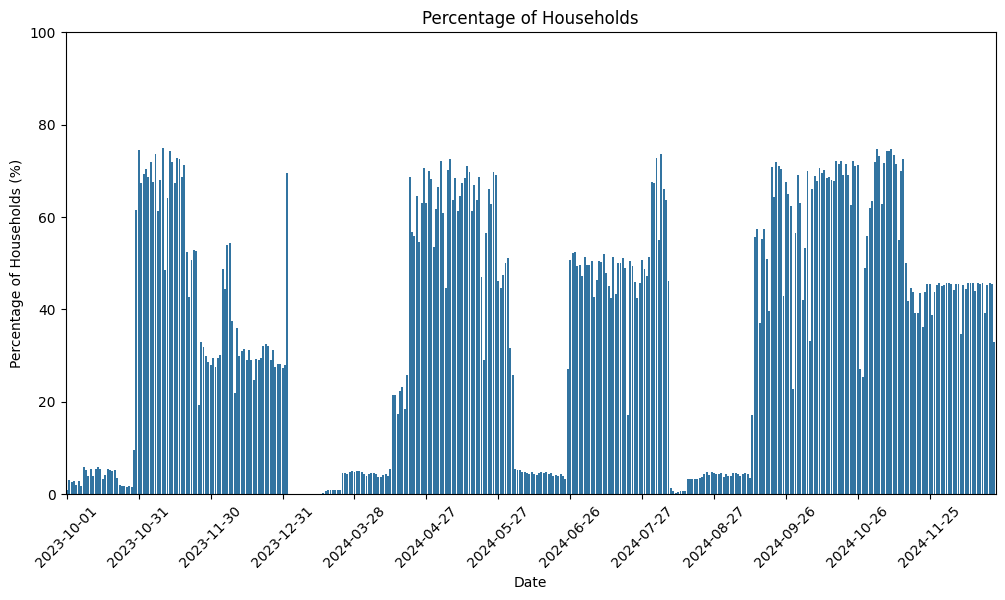

In [53]:
# ahousehold should have 96 dataponts for a day, plotting the percentage

total_households = merged['household_ID'].nunique()
counts = merged.groupby(['date', 'household_ID']).size()
full_reporting = counts[counts == 96].groupby('date').count()

percentage_per_day = (full_reporting / total_households) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_per_day.index, y=percentage_per_day.values)
# x axis only should only show from month to month
plt.xticks(ticks=range(0, len(percentage_per_day.index), 30), labels=percentage_per_day.index[::30], rotation=45)
# y axis should go till 100
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.title('Percentage of Households')
plt.xlabel('Date')
plt.ylabel('Percentage of Households (%)')


In [48]:
full_reporting

date
2023-10-01      48
2023-10-02     158
2023-10-03     144
2023-10-04     142
2023-10-05     115
              ... 
2024-12-18    1147
2024-12-19    1309
2024-12-20    1321
2024-12-21    1316
2024-12-22     973
Length: 396, dtype: int64

In [44]:
(676 / total_households)*100

23.008849557522122

In [42]:
nsix

date
2023-10-01     131.802083
2023-10-02     166.802083
2023-10-03     167.041667
2023-10-04     167.739583
2023-10-05     161.916667
                 ...     
2024-12-19    1325.083333
2024-12-20    1325.208333
2024-12-21    1325.083333
2024-12-22    1317.000000
2024-12-23     676.145833
Name: household_ID, Length: 407, dtype: float64

### Time-recorded Density Graph

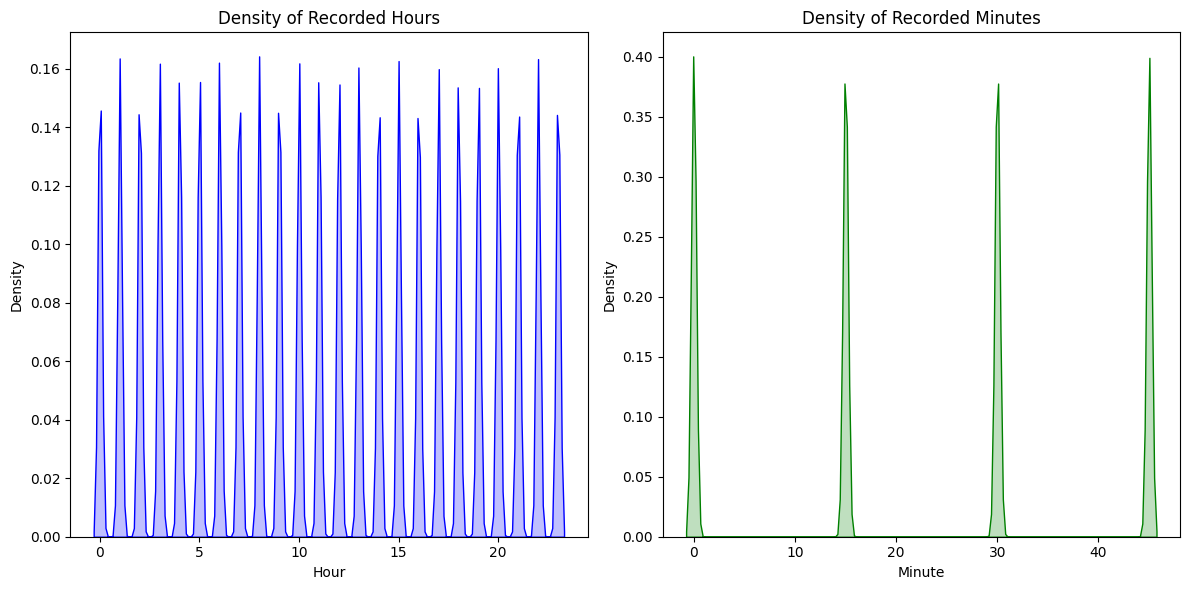

In [4]:
all_data_filtered['Hour'] = all_data_filtered['DATETIME'].dt.hour
all_data_filtered['Minute'] = all_data_filtered['DATETIME'].dt.minute

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(all_data_filtered['Hour'], fill=True, color='blue', bw_adjust=0.5)
plt.title('Density of Recorded Hours')
plt.xlabel('Hour')
plt.ylabel('Density')


plt.subplot(1, 2, 2)
sns.kdeplot(all_data_filtered['Minute'], fill=True, color='green', bw_adjust=0.5)
plt.title('Density of Recorded Minutes')
plt.xlabel('Minute')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [5]:
all_data_filtered['importkwh(kwh)'] = pd.to_numeric(all_data_filtered['importkwh(kwh)'], errors='coerce')
all_data_filtered['exportkwh(kwh)'] = pd.to_numeric(all_data_filtered['exportkwh(kwh)'], errors='coerce')

rows, cols = all_data_filtered.shape
print(f'total rows read : {total}')
print(f'total rows in the dataframe : {rows}')

total rows read : 45613280
total rows in the dataframe : 45613280


In [6]:
all_data_filtered.isnull().sum()

household_ID      0
date              0
time              0
importkwh(kwh)    0
exportkwh(kwh)    0
DATETIME          0
Hour              0
Minute            0
dtype: int64

In [7]:
'''
since each consumption point is a cumulative conusmption we need to substract every datapoint from 
its previous datapoint to get the exact consumption between the timestamps by considering houshold id
'''
# Important: sort the dataset before substracting  
all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

all_data_filtered[['importkwh(kwh)', 'exportkwh(kwh)']] = (
    all_data_filtered.groupby('household_ID')[['importkwh(kwh)', 'exportkwh(kwh)']].diff()
)

In [8]:
(all_data_filtered[['importkwh(kwh)', 'exportkwh(kwh)']] < 0).sum()

importkwh(kwh)    4249
exportkwh(kwh)    3529
dtype: int64

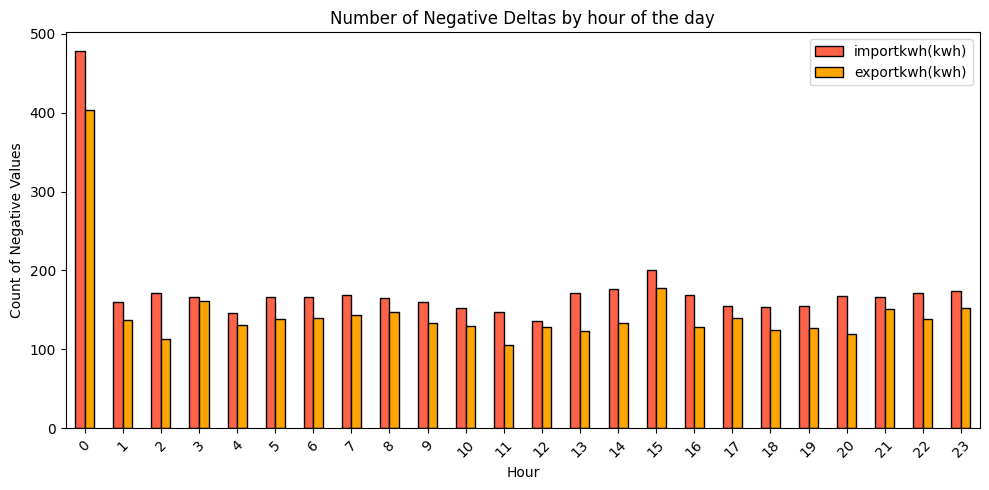

In [9]:
negatives = all_data_filtered[
    (all_data_filtered['importkwh(kwh)'] < 0) |
    (all_data_filtered['exportkwh(kwh)'] < 0)
]

neg_counts = negatives.groupby('Hour')[['importkwh(kwh)', 'exportkwh(kwh)']].apply(
    lambda df: (df < 0).sum()
)

neg_counts.plot(kind='bar', figsize=(10, 5), color=['tomato', 'orange'], edgecolor='black')
plt.title("Number of Negative Deltas by hour of the day")
plt.ylabel("Count of Negative Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### close to 10K negative TOTAL_IMPORT? That’s interesting lets try to explore whats actually happenning under the hood by examining single househods

In [10]:
negatives

,household_ID,date,time,importkwh(kwh),exportkwh(kwh),DATETIME,Hour,Minute
22006304,ID0111,2024-11-04,15:15:00,-0.1320,0.000,2024-11-04 15:15:00,15,15
22277657,ID0113,2024-11-05,15:15:00,-0.0991,0.000,2024-11-05 15:15:00,15,15
9545612,ID0457,2024-08-02,00:00:00,-5286.7639,1209.077,2024-08-02 00:00:00,0,0
9547067,ID0457,2024-08-02,00:15:00,5286.7919,-1209.077,2024-08-02 00:15:00,0,15
9657133,ID0457,2024-08-03,00:00:00,-5288.0400,1228.695,2024-08-03 00:00:00,0,0
...,...,...,...,...,...,...,...,...
21276481,ID5569,2024-10-31,14:15:00,-31243.1900,33296.450,2024-10-31 14:15:00,14,15
21276503,ID5569,2024-10-31,14:45:00,31245.6300,-33297.150,2024-10-31 14:45:00,14,45
21275953,ID5569,2024-10-31,15:30:00,-31246.9600,33299.530,2024-10-31 15:30:00,15,30
21281509,ID5569,2024-10-31,21:00:00,31248.7900,-33301.390,2024-10-31 21:00:00,21,0


In [11]:
# we have 154 households experiencing negative values in electricity consumption or exportation
# we explored what CSC areas has this problem frequently - it was spread throughout all the areas
# Therefore we explored what households experiencing this frequently
households = set(negatives['household_ID'])
len(households)

121

In [12]:
negative_houses = survey[survey.household_ID.isin(households)]
negative_houses.electricity_provider_csc_area.value_counts()

electricity_provider_csc_area
MORATUWA NORTH    28
PANADURA           9
MORATUWA SOUTH     6
BORALASGAMUWA      3
DALUGAMA           2
KESELWATTA         2
NUGEGODA           2
MAHARAGAMA         1
MAHARA             1
Name: count, dtype: int64

In [13]:
negatives.household_ID.value_counts().head(20)

household_ID
ID5569    737
ID4896    656
ID0844    632
ID1683    596
ID4505    578
ID5288    500
ID4342    482
ID0551    410
ID1751    377
ID5483    370
ID5543    323
ID3058    270
ID0457    249
ID5243    234
ID2747    218
ID5434    161
ID4695    149
ID5081    130
ID5050    120
ID4142    102
Name: count, dtype: int64

##### Example household 1

In [14]:
negatives[negatives['household_ID'] == 'ID5569']

,household_ID,date,time,importkwh(kwh),exportkwh(kwh),DATETIME,Hour,Minute
38225705,ID5569,2024-05-29,16:30:00,-28464.77,30280.40,2024-05-29 16:30:00,16,30
38225364,ID5569,2024-05-29,17:15:00,28465.27,-30280.49,2024-05-29 17:15:00,17,15
38224917,ID5569,2024-05-29,20:30:00,-28464.53,30280.52,2024-05-29 20:30:00,20,30
38224739,ID5569,2024-05-29,21:15:00,28464.35,-30280.52,2024-05-29 21:15:00,21,15
38460986,ID5569,2024-05-30,01:00:00,-28463.03,30280.51,2024-05-30 01:00:00,1,0
...,...,...,...,...,...,...,...,...
21276481,ID5569,2024-10-31,14:15:00,-31243.19,33296.45,2024-10-31 14:15:00,14,15
21276503,ID5569,2024-10-31,14:45:00,31245.63,-33297.15,2024-10-31 14:45:00,14,45
21275953,ID5569,2024-10-31,15:30:00,-31246.96,33299.53,2024-10-31 15:30:00,15,30
21281509,ID5569,2024-10-31,21:00:00,31248.79,-33301.39,2024-10-31 21:00:00,21,0


In [15]:
# seems like the recorded data is crashed or junk

all_data_filtered[all_data_filtered['household_ID'] == 'ID5569'].head(307)

,household_ID,date,time,importkwh(kwh),exportkwh(kwh),DATETIME,Hour,Minute
38230456,ID5569,2024-05-29,10:45:00,NaN,NaN,2024-05-29 10:45:00,10,45
38230408,ID5569,2024-05-29,11:00:00,0.60,0.0,2024-05-29 11:00:00,11,0
38230551,ID5569,2024-05-29,11:15:00,0.51,0.0,2024-05-29 11:15:00,11,15
38230505,ID5569,2024-05-29,11:30:00,0.67,0.0,2024-05-29 11:30:00,11,30
38231214,ID5569,2024-05-29,11:45:00,1.06,0.0,2024-05-29 11:45:00,11,45
...,...,...,...,...,...,...,...,...
9709822,ID5569,2024-08-03,03:45:00,29602.22,-31515.8,2024-08-03 03:45:00,3,45
9709821,ID5569,2024-08-03,04:00:00,0.00,0.0,2024-08-03 04:00:00,4,0
9709820,ID5569,2024-08-03,04:15:00,0.00,0.0,2024-08-03 04:15:00,4,15
9709819,ID5569,2024-08-03,04:30:00,0.00,0.0,2024-08-03 04:30:00,4,30


#### Removing the crashed records 

In [16]:
all_data_filtered = all_data_filtered.drop(negatives.index)

#### Density of Records

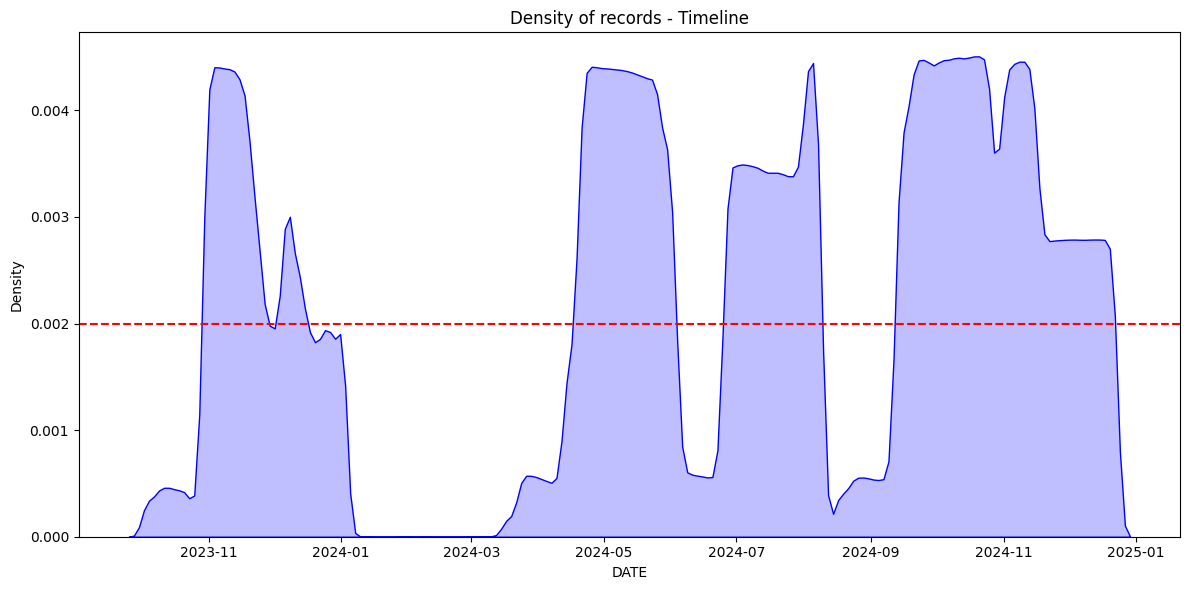

In [17]:
# Kernel Density Estimation (KDE) probability density function

plt.figure(figsize=(12, 6))
density_threshold = 0.002

sns.kdeplot(all_data_filtered['DATETIME'], fill=True, color='blue', bw_adjust=0.5)
plt.axhline(y=density_threshold, color='red', linestyle='--', label='Density Threshold = 0.002')
plt.title('Density of records - Timeline')
plt.xlabel('DATE')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

<Axes: xlabel='DATETIME'>

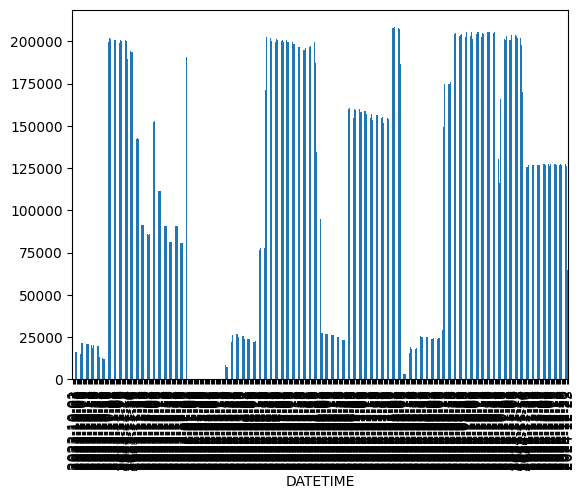

In [18]:
all_data_filtered['DATETIME'].dt.date.value_counts().sort_index().plot(kind='bar')

In [19]:
# merging with survey data
merged = all_data_filtered.merge(survey[['household_ID', 'socio_economic_class']], left_on=all_data_filtered.household_ID, right_on=survey.household_ID, how='left')

#### filtering the dataframe to consider a dense period of data records

In [20]:
# Method 01: using predefined time interval
start_date = '2024-09-01 00:00:00'
end_date = '2025-01-01 00:00:00'

filtered_df = merged[(merged['DATETIME'] >= start_date) & (merged['DATETIME'] < end_date)]

In [21]:
# Method 02: Using Kernel density estimation

bin_counts = merged['Hour'].value_counts(normalize=True)
# Filter bins with density > threshold
valid_bins = bin_counts[bin_counts > 0.0015].index
filtered_df = merged[merged['Hour'].isin(valid_bins)]

#### Daily Import Trend

<Axes: xlabel='time'>

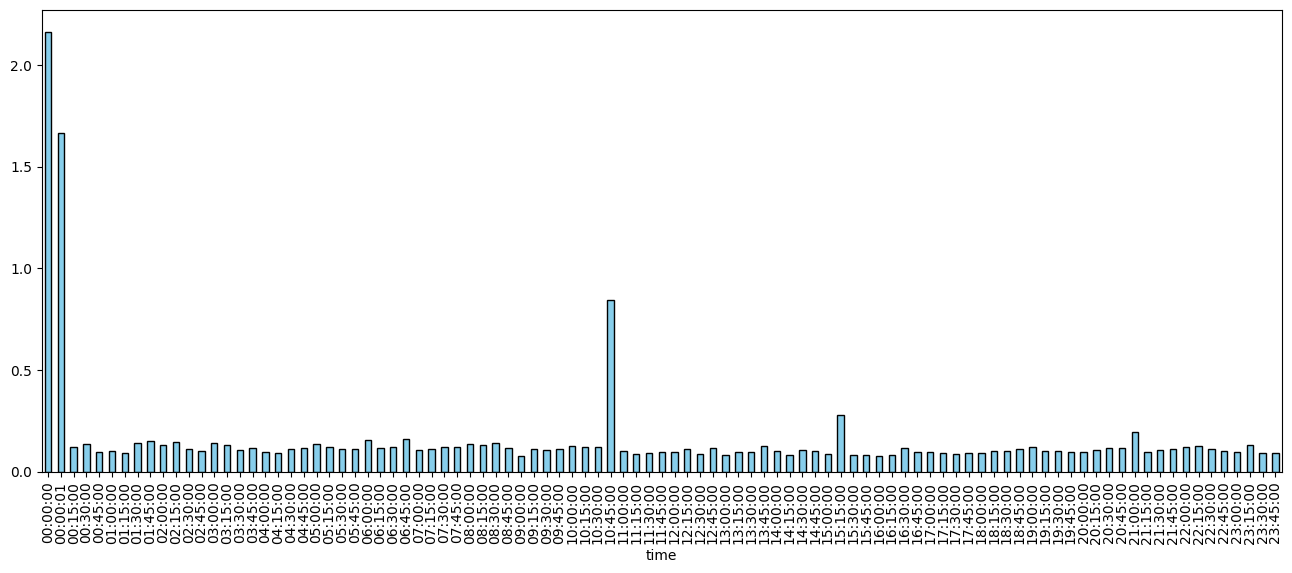

In [24]:
filtered_for_import = filtered_df[filtered_df['exportkwh(kwh)'] == 0]
daily_import = filtered_for_import.groupby('time')['importkwh(kwh)'].mean()

plt.figure(figsize=(16, 6))
daily_import.plot( kind='bar', color='skyblue', edgecolor='black')

#### Daily Export Trend

<Axes: xlabel='time'>

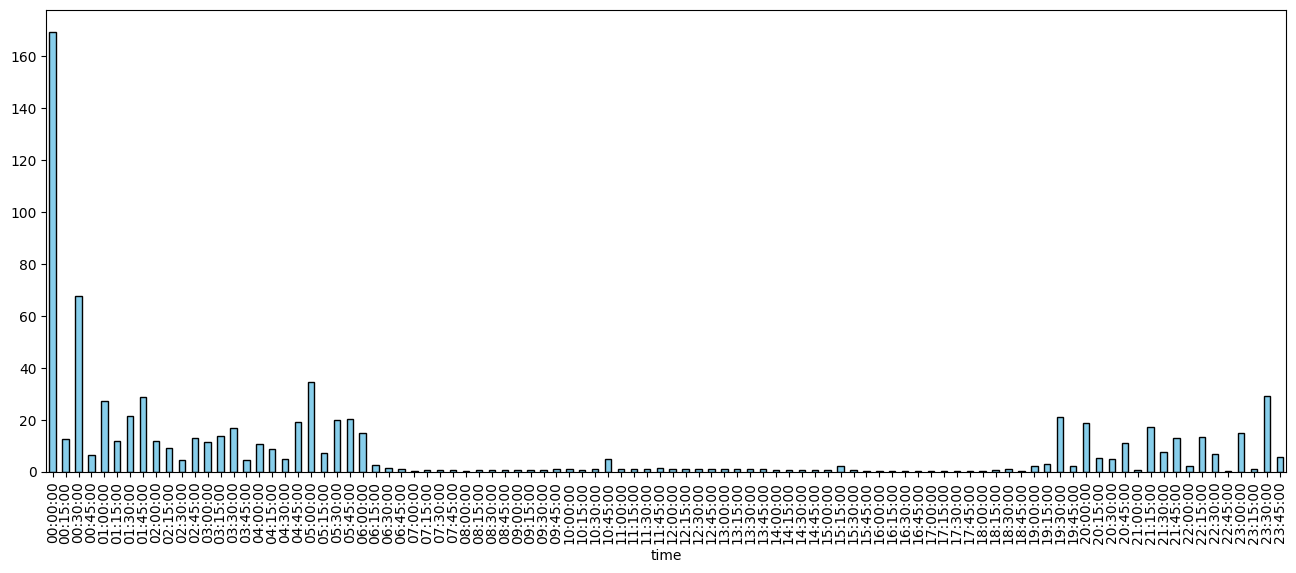

In [44]:
filtered_for_export = filtered_df[filtered_df['exportkwh(kwh)'] > 0]
daily_export = filtered_for_export.groupby('time')['exportkwh(kwh)'].mean()

plt.figure(figsize=(16, 6))
daily_export.plot( kind='bar', color='skyblue', edgecolor='black')